### ID3

In [144]:
import math
from tqdm import tqdm

class ID3:
    
    class Node:
        def __init__(self):
            self.feature = None
            self.subtree0 = None
            self.subtree1 = None
            self.prediction = None
            self.depth = None
            
    def IG(self, class_, feature):
        classes = set(class_)

        Hc = 0
        for c in classes:
            pc = list(class_).count(c)/len(class_)
            Hc += - pc * math.log(pc, 2)
        #print('Overall Entropy:', Hc)
        feature_values = set(feature)

        Hc_feature = 0
        for feat in feature_values:
            
            #pf --> P(X=x)
            pf = list(feature).count(feat)/len(feature)
            indices = [i for i in range(len(feature)) if feature[i] == feat]
            clasess_of_feat = [class_[i] for i in indices]
            for c in classes:
                #pcf --> P(C=c|X=x)
                pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
                if pcf != 0: 
                    # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                    temp_H = - pf * pcf * math.log(pcf, 2)
                    #sum for all values of C (class) and X (values of specific feature)
                    Hc_feature += temp_H
        ig = Hc - Hc_feature
        return ig


    def create_tree(self, x_examples_binary, y_examples, default=0, max_depth = None, current_depth = None):
        # Create root node
        root = self.Node()
        
        if current_depth == None:
            root.depth = 0
        else:
            root.depth = current_depth
            
        # When there are no examples
        if len(y_examples)==0:
            root.prediction = default
            return root
        
        # When there are no features, we return the most common category from y_examples
        sum_y = 0
        for i in y_examples:
            sum_y += i
        if len(x_examples_binary[0]) == 0:
            root.prediction = round(sum_y/len(y_examples))
            return root
        
        # Reach max depth
        if max_depth != None:
            if max_depth <= root.depth:
                root.prediction = round(sum_y/len(y_examples))
                return root

        # When all examples are in the same category
        if sum_y == 0 or sum_y == len(y_examples):
            root.prediction = y_examples[0]
            return root
        
        # Find the best feature that give us the max information gain
        informationGain = []
        featureValues = []
        
        max_ig=0
        max_feature_index = 0
        
        for i in range(len(x_examples_binary[0])):
            featureValues.append([example[i] for example in x_examples_binary])
            informationGain.append(self.IG(y_examples, featureValues[i]))
            if informationGain[i]>max_ig:
                max_ig = informationGain[i]
                max_feature_index = i
                                    
        root.feature = max_feature_index
        
        del(informationGain)
        del(featureValues)
                    
        # Find the category of each example based on the best feature
        x_examples0 = []
        y_examples0 = []
        x_examples1 = []
        y_examples1 = []
        
        for i in range(len(x_examples_binary)):
            if x_examples_binary[i][max_feature_index] == 0:
                x_examples0.append([inst for inst in x_examples_binary[i]])
                y_examples0.append(y_examples[i])
            else:
                x_examples1.append([inst for inst in x_examples_binary[i]])
                y_examples1.append(y_examples[i])
                
        # Remove the best feature and create a subtree for each category of the examples
        for i in range(len(x_examples0)): 
            x_examples0[i].pop(max_feature_index)
        for i in range(len(x_examples1)): 
            x_examples1[i].pop(max_feature_index)

        # print(root.depth)
        
        root.subtree0 = self.create_tree(x_examples0, y_examples0, max_depth=max_depth, current_depth=root.depth+1)
        root.subtree1 = self.create_tree(x_examples1, y_examples1, max_depth=max_depth, current_depth=root.depth+1)
                
        return root

    # Function to predict a single example
    def predict_example(self, x, tree_root):
        if tree_root.prediction != None:
            return tree_root.prediction

        elif x[tree_root.feature] == 0:
            tree_root = tree_root.subtree0
            return self.predict_example(x, tree_root)
        
        else:
            tree_root = tree_root.subtree1
            return self.predict_example(x, tree_root)
    
    
    # Function to predict an array of examples and returns an array of categories  for each example  
    def predict(self, x, tree_root):
        y = []
        for i in range(len(x)):
            y.append(self.predict_example(x[i], tree_root))
        
        return y

    # Function to calculate the accuracy. ((true pos + true negs) / all samples)
    def accuracy(self, x, y, tree):
        counter = 0
        for i in range(len(y)):
            if self.predict_example(x[i], tree) == y[i]:
                counter+=1
        return float(counter/len(y))
    
    # Function to calculate the precision. (true pos / (true pos + false pos))
    def precision(self, x, y, tree):
        true_pos = 0
        true_pred = 0
        predictions = self.predict(x, tree)
        for i in range(len(predictions)):
            true_pred += predictions[i]
            if predictions[i] == 1 and y[i] == 1:
                true_pos +=1
        return float(true_pos/true_pred)
    
    # Function to calculate the recall. (true pos / (true pos + false neg))
    def recall(self, x, y, tree):
        true_pos = 0
        true_actual = 0
        predictions = self.predict(x, tree)
        for i in range(len(y)):
            true_actual += y[i]
            if predictions[i] == 1 and y[i] == 1:
                true_pos += 1
        return float(true_pos/true_actual)

    # Function to create data for graphs. Returns an array with size=4.
    # array[0] = x axis, array[1] = y accuracy, array[2] = y precision, array[3] = y recall
    def create_graph_data(self, x_train, y_train, x_test, y_test, x_start, x_step):
        i=x_start
        x_graph = []
        y_graph_accuracy = []
        y_graph_precision = []
        y_graph_recall = []
        for i in tqdm(range(x_start, len(y_train), x_step)):
            x = x_train[0:i]
            y = y_train[0:i]
            tree = self.create_tree(x, y)
            x_graph.append(i)
            y_graph_accuracy.append(self.accuracy(x_test, y_test, tree))
            y_graph_precision.append(self.precision(x_test, y_test, tree))
            y_graph_recall.append(self.recall(x_test, y_test, tree))

        return [x_graph, y_graph_accuracy, y_graph_precision, y_graph_recall]



### Fetch data

In [145]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=4000)

word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

In [146]:
x_train = x_train[0:10000]
y_train = y_train[0:10000]
x_test = x_test[0:10000]
y_test = y_test[0:10000]

In [147]:
vocabulary = list()
for text in x_train:
  tokens = text.split()
  vocabulary.extend(tokens)

vocabulary = set(vocabulary)
print(len(vocabulary))

3998


In [148]:
from tqdm import tqdm

x_train_binary = list()
x_test_binary = list()

for text in tqdm(x_train):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_train_binary.append(binary_vector)

x_train_binary = np.array(x_train_binary)

for text in tqdm(x_test):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_test_binary.append(binary_vector)

x_test_binary = np.array(x_test_binary)

100%|██████████| 10000/10000 [02:35<00:00, 64.50it/s]


### Classification report

In [149]:
id = ID3()
tree = id.create_tree(x_train_binary, y_train, max_depth=5)

In [150]:
from sklearn.metrics import classification_report
report = classification_report(y_test, id.predict(x_test_binary, tree))
print(report)

              precision    recall  f1-score   support

           0       0.46      0.02      0.03      5027
           1       0.50      0.98      0.66      4973

    accuracy                           0.50     10000
   macro avg       0.48      0.50      0.35     10000
weighted avg       0.48      0.50      0.34     10000



### Generate data for graphs

In [151]:
x=[]
y_precision=[]
y_recall=[]
y_accuracy=[]
i=1

for i in tqdm(range(1, len(x_test_binary), 500)):
    x.append(i)
    y_precision.append(id.precision(x_test_binary[0:i], y_test[0:i], tree))
    y_recall.append(id.recall(x_test_binary[0:i], y_test[0:i], tree))
    y_accuracy.append(id.accuracy(x_test_binary[0:i], y_test[0:i], tree))



  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\mikel\AppData\Local\Temp\ipykernel_5692\1081786504.py:175: RuntimeWarning: invalid value encountered in longlong_scalars
  return float(true_pos/true_actual)
100%|██████████| 20/20 [00:00<00:00, 22.01it/s]


In [152]:
x=[]
y_precision_train=[]
y_recall_train=[]
y_accuracy_train=[]
i=1

for i in tqdm(range(1, len(x_train_binary), 500)):
    x.append(i)
    y_precision_train.append(id.precision(x_train_binary[0:i], y_train[0:i], tree))
    y_recall_train.append(id.recall(x_train_binary[0:i], y_train[0:i], tree))
    y_accuracy_train.append(id.accuracy(x_train_binary[0:i], y_train[0:i], tree))


100%|██████████| 20/20 [00:01<00:00, 19.25it/s]


### Implement scikit learn model

In [153]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='entropy')
dt.fit(x_train_binary, y_train)

DecisionTreeClassifier(criterion='entropy')

In [154]:
from sklearn.metrics import classification_report
report = classification_report(y_train, dt.predict(x_train_binary))
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4947
           1       1.00      1.00      1.00      5053

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [155]:
from sklearn.metrics import classification_report
report = classification_report(y_test, dt.predict(x_test_binary))
print(report)

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      5027
           1       0.70      0.70      0.70      4973

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



### Generate data for graphs

In [156]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm import tqdm

# make data
x=[]
y_precision_dt=[]
y_recall_dt=[]
y_f1_dt=[]
i=1

for i in tqdm(range(1, len(x_test_binary),500)):
    x.append(i)
    y_precision_dt.append(precision_score(y_test[0:i], dt.predict(x_test_binary[0:i]), average='weighted'))
    y_recall_dt.append(recall_score(y_test[0:i], dt.predict(x_test_binary[0:i]), average='weighted'))
    y_f1_dt.append(f1_score(y_test[0:i], dt.predict(x_test_binary[0:i]), average='weighted'))

100%|██████████| 20/20 [00:03<00:00,  5.54it/s]


In [157]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm import tqdm

# make data
x=[]
y_precision_dt_train=[]
y_recall_dt_train=[]
y_f1_dt_train=[]
i=1

for i in tqdm(range(1, len(x_train_binary),500)):
    x.append(i)
    y_precision_dt_train.append(precision_score(y_train[0:i], dt.predict(x_train_binary[0:i]), average='weighted'))
    y_recall_dt_train.append(recall_score(y_train[0:i], dt.predict(x_train_binary[0:i]), average='weighted'))
    y_f1_dt_train.append(f1_score(y_train[0:i], dt.predict(x_train_binary[0:i]), average='weighted'))

100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


### Implement MLP model

In [158]:
imdb_mlp = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(3998,)),
      tf.keras.layers.Dense(units=256, activation='relu'),
      tf.keras.layers.Dropout(rate=0.2),
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dropout(rate=0.5),
      tf.keras.layers.Dense(units=1, activation='sigmoid')
])


In [159]:
imdb_mlp.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.SGD(),
                  metrics=['binary_accuracy'])
imdb_mlp.fit(x=x_train_binary, y=y_train,
             epochs=10, verbose=1, batch_size=32)

Epoch 1/10
313/313 [==============================] - 4s 8ms/step - loss: 0.6893 - binary_accuracy: 0.5438
Epoch 2/10
313/313 [==============================] - 2s 8ms/step - loss: 0.6395 - binary_accuracy: 0.6554
Epoch 3/10
313/313 [==============================] - 2s 8ms/step - loss: 0.5268 - binary_accuracy: 0.7591
Epoch 4/10
313/313 [==============================] - 2s 8ms/step - loss: 0.4276 - binary_accuracy: 0.8184
Epoch 5/10
313/313 [==============================] - 3s 8ms/step - loss: 0.3660 - binary_accuracy: 0.8493
Epoch 6/10
313/313 [==============================] - 2s 8ms/step - loss: 0.3331 - binary_accuracy: 0.8694
Epoch 7/10
313/313 [==============================] - 2s 8ms/step - loss: 0.2986 - binary_accuracy: 0.8874
Epoch 8/10
313/313 [==============================] - 2s 8ms/step - loss: 0.2668 - binary_accuracy: 0.9020
Epoch 9/10
313/313 [==============================] - 3s 8ms/step - loss: 0.2456 - binary_accuracy: 0.9075
Epoch 10/10
313/313 [================

In [160]:
imdb_mlp = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(3998,)),
      tf.keras.layers.Dense(units=256, activation='relu'),
      tf.keras.layers.Dropout(rate=0.2),
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dropout(rate=0.5),
      tf.keras.layers.Dense(units=1, activation='sigmoid')
])

imdb_mlp.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.SGD(),
                  metrics=['binary_accuracy'])
imdb_mlp.fit(x=x_train_binary, y=y_train,
             epochs=10, verbose=1, batch_size=32)




def mlp_precision(x, y, predictions):
    true_pos = 0
    true_actual = 0
    for i in range(len(y)):
        true_actual += y[i]
        if predictions[i] == 1 and y[i] == 1:
            true_pos += 1
    return float(true_pos/true_actual)

def mlp_accuracy(x, y, predictions):
    counter = 0
    for i in range(len(y)):
        if predictions[i] == y[i]:
            counter += 1
    return float(counter/len(y))

def mlp_recall(x, y, predictions):
    true_pos = 0
    true_actual = 0
    for i in range(len(y)):
        true_actual += y[i]
        if predictions[i] == 1 and y[i] == 1:
            true_pos += 1
    
    return float(true_pos/true_actual)


Epoch 1/10
313/313 [==============================] - 3s 9ms/step - loss: 0.6863 - binary_accuracy: 0.5408
Epoch 2/10
313/313 [==============================] - 2s 8ms/step - loss: 0.6392 - binary_accuracy: 0.6626
Epoch 3/10
313/313 [==============================] - 2s 8ms/step - loss: 0.5195 - binary_accuracy: 0.7618
Epoch 4/10
313/313 [==============================] - 3s 8ms/step - loss: 0.4267 - binary_accuracy: 0.8177
Epoch 5/10
313/313 [==============================] - 3s 8ms/step - loss: 0.3646 - binary_accuracy: 0.8496
Epoch 6/10
313/313 [==============================] - 2s 8ms/step - loss: 0.3216 - binary_accuracy: 0.8697
Epoch 7/10
313/313 [==============================] - 3s 8ms/step - loss: 0.2910 - binary_accuracy: 0.8856
Epoch 8/10
313/313 [==============================] - 3s 8ms/step - loss: 0.2595 - binary_accuracy: 0.8993
Epoch 9/10
313/313 [==============================] - 3s 8ms/step - loss: 0.2332 - binary_accuracy: 0.9112
Epoch 10/10
313/313 [================

### Generate data for graphs

In [161]:
preds = imdb_mlp.predict(x_test_binary)
for i in range(len(preds)):
    preds[i] = round(preds[i][0])

y_precision_mlp=[]
y_recall_mlp=[]
y_accuracy_mlp=[]
i=1

for i in tqdm(range(1, len(x_test_binary), 500)):
    y_precision_mlp.append(mlp_precision(x_test_binary[0:i], y_test[0:i], preds))
    y_recall_mlp.append(mlp_recall(x_test_binary[0:i], y_test[0:i], preds))
    y_accuracy_mlp.append(mlp_accuracy(x_test_binary[0:i], y_test[0:i], preds))

313/313 [==============================] - 1s 3ms/step


  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\mikel\AppData\Local\Temp\ipykernel_5692\1001057664.py:27: RuntimeWarning: invalid value encountered in longlong_scalars
  return float(true_pos/true_actual)
C:\Users\mikel\AppData\Local\Temp\ipykernel_5692\1001057664.py:44: RuntimeWarning: invalid value encountered in longlong_scalars
  return float(true_pos/true_actual)
100%|██████████| 20/20 [00:00<00:00, 21.68it/s]


In [162]:
preds = imdb_mlp.predict(x_train_binary)
for i in range(len(preds)):
    preds[i] = round(preds[i][0])

y_precision_mlp_train=[]
y_recall_mlp_train=[]
y_accuracy_mlp_train=[]
i=1

for i in tqdm(range(1, len(x_train_binary), 500)):
    y_precision_mlp_train.append(mlp_precision(x_train_binary[0:i], y_train[0:i], preds))
    y_recall_mlp_train.append(mlp_recall(x_train_binary[0:i], y_train[0:i], preds))
    y_accuracy_mlp_train.append(mlp_accuracy(x_train_binary[0:i], y_train[0:i], preds))



313/313 [==============================] - 1s 4ms/step


100%|██████████| 20/20 [00:00<00:00, 20.91it/s]


### Graphs for test data

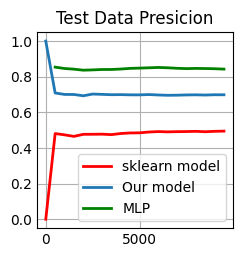

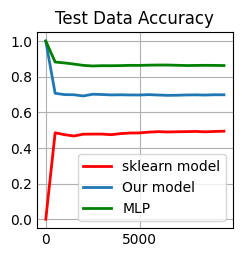

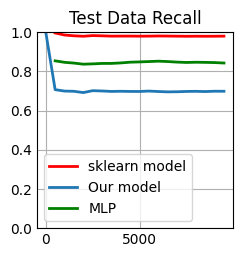

In [163]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# plot
fig, ax = plt.subplots()

ax.plot(x, y_precision, linewidth=2.0, color='red', label='sklearn model')
ax.plot(x, y_precision_dt, linewidth=2.0, label='Our model')
ax.plot(x, y_precision_mlp, linewidth=2.0, color='green', label='MLP')
ax.legend()
plt.title('Test Data Presicion')


plt.style.use('_mpl-gallery')

# plot
fig, ax = plt.subplots()

ax.plot(x, y_accuracy, linewidth=2.0, color='red', label='sklearn model')
ax.plot(x, y_f1_dt, linewidth=2.0, label='Our model')
ax.plot(x, y_accuracy_mlp, linewidth=2.0, color='green', label='MLP')

ax.legend()
plt.title('Test Data Accuracy')


plt.style.use('_mpl-gallery')

# plot
fig, ax = plt.subplots()

ax.plot(x, y_recall, linewidth=2.0, color='red', label='sklearn model')
ax.plot(x, y_recall_dt, linewidth=2.0, label='Our model')
ax.plot(x, y_recall_mlp, linewidth=2.0, color='green', label='MLP')

ax.legend()
plt.title('Test Data Recall')
plt.ylim(0,1)

plt.show()

### Graphs for training data

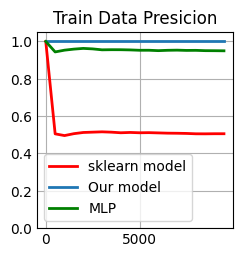

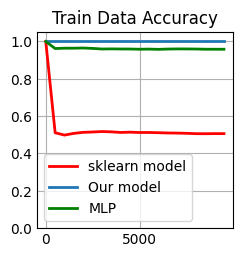

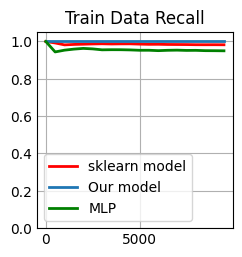

In [164]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# plot
fig, ax = plt.subplots()

ax.plot(x, y_precision_train, linewidth=2.0, color='red', label='sklearn model')
ax.plot(x, y_precision_dt_train, linewidth=2.0, label='Our model')
ax.plot(x, y_precision_mlp_train, linewidth=2.0, color='green', label='MLP')
ax.legend()
plt.title('Train Data Presicion')
plt.ylim(0,1.05)


plt.style.use('_mpl-gallery')

# plot
fig, ax = plt.subplots()

ax.plot(x, y_accuracy_train, linewidth=2.0, color='red', label='sklearn model')
ax.plot(x, y_f1_dt_train, linewidth=2.0, label='Our model')
ax.plot(x, y_accuracy_mlp_train, linewidth=2.0, color='green', label='MLP')

ax.legend()
plt.title('Train Data Accuracy')
plt.ylim(0,1.05)


plt.style.use('_mpl-gallery')

# plot
fig, ax = plt.subplots()

ax.plot(x, y_recall_train, linewidth=2.0, color='red', label='sklearn model')
ax.plot(x, y_recall_dt_train, linewidth=2.0, label='Our model')
ax.plot(x, y_recall_mlp_train, linewidth=2.0, color='green', label='MLP')

ax.legend()
plt.title('Train Data Recall')
plt.ylim(0,1.05)

plt.show()